In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from torchvision.utils import save_image

In [8]:
DATASET_DIR = r"D:\data0\lsun\bedroom"
MODEL_PATH = "gan1"
EPOCHS = 5
NZ = 100  # Size of z latent vector (i.e. size of generator input)
NGF = 64  # Size of feature maps in generator
NDF = 64  # Size of feature maps in discriminator
NC = 3    # Number of channels in the training images (3 for RGB images)
LR = 0.0002
BETA1 = 0.5
BATCH_SIZE = 128

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing to [-1, 1]
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)

# Take 50% of the dataset
total_len = len(dataset)
final_subset_indices = np.random.choice(total_len, int(0.5 * total_len), replace=False)

# Create the final subset dataset
subset_dataset = Subset(dataset, final_subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

In [64]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [65]:
netG = Generator(NZ, NGF, NC).to(device)
netD = Discriminator(NC, NDF).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [66]:
fixed_noise = torch.randn(64, NZ, 1, 1, device=device)
count = 0

# Training Loop
for epoch in range(EPOCHS):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), 1., dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()
        
        noise = torch.randn(batch_size, NZ, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(0.)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        
        optimizerD.step()
        
        lossD = lossD_real + lossD_fake

        # Update Generator
        netG.zero_grad()
        labels.fill_(1.)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        # Print training stats
        if i % 100 == 0:
            count = count + 1
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            save_image(fake, f'gan/images/fake_samples_{count}.png', normalize=True)
            print(f'Epoch [{epoch+1}/{EPOCHS}] Batch [{i}/{len(dataloader)}] '
                  f'Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}')

Epoch [1/5] Batch [0/4737] Loss D: 1.5684, Loss G: 4.2837
Epoch [1/5] Batch [100/4737] Loss D: 0.7267, Loss G: 3.6453
Epoch [1/5] Batch [200/4737] Loss D: 0.3193, Loss G: 5.5994
Epoch [1/5] Batch [300/4737] Loss D: 0.3413, Loss G: 5.5802
Epoch [1/5] Batch [400/4737] Loss D: 0.5112, Loss G: 3.9956
Epoch [1/5] Batch [500/4737] Loss D: 0.8772, Loss G: 6.3304
Epoch [1/5] Batch [600/4737] Loss D: 0.3796, Loss G: 5.2238
Epoch [1/5] Batch [700/4737] Loss D: 0.3357, Loss G: 3.0494
Epoch [1/5] Batch [800/4737] Loss D: 0.4573, Loss G: 5.5914
Epoch [1/5] Batch [900/4737] Loss D: 0.4128, Loss G: 2.8171
Epoch [1/5] Batch [1000/4737] Loss D: 0.1903, Loss G: 4.0006
Epoch [1/5] Batch [1100/4737] Loss D: 0.5195, Loss G: 4.1069
Epoch [1/5] Batch [1200/4737] Loss D: 0.3444, Loss G: 4.1379
Epoch [1/5] Batch [1300/4737] Loss D: 0.4284, Loss G: 4.9516
Epoch [1/5] Batch [1400/4737] Loss D: 0.4957, Loss G: 4.2802
Epoch [1/5] Batch [1500/4737] Loss D: 0.3100, Loss G: 4.5036
Epoch [1/5] Batch [1600/4737] Loss D

In [67]:
generator_path = f'{MODEL_PATH}/netG.pth'
discriminator_path = f'{MODEL_PATH}/netD.pth'
optimizerG_path = f'{MODEL_PATH}/optimizerG.pth'
optimizerD_path = f'{MODEL_PATH}/optimizerD.pth'

torch.save(netG.state_dict(), generator_path)
torch.save(netD.state_dict(), discriminator_path)
torch.save(optimizerG.state_dict(), optimizerG_path)
torch.save(optimizerD.state_dict(), optimizerD_path)

print("Models and optimizers saved successfully.")

Models and optimizers saved successfully.


In [68]:
netG = Generator(NZ, NGF, NC).to(device)

netG.load_state_dict(torch.load(f'{MODEL_PATH}/netG.pth'))
netG.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [69]:
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
save_image(fake, f'{MODEL_PATH}/images/fake_samples.png', normalize=True)

In [2]:
import matplotlib.pyplot as plt

data = """
Epoch [1/5] Batch [0/4737] Loss D: 1.5684, Loss G: 4.2837
Epoch [1/5] Batch [100/4737] Loss D: 0.7267, Loss G: 3.6453
Epoch [1/5] Batch [200/4737] Loss D: 0.3193, Loss G: 5.5994
Epoch [1/5] Batch [300/4737] Loss D: 0.3413, Loss G: 5.5802
Epoch [1/5] Batch [400/4737] Loss D: 0.5112, Loss G: 3.9956
Epoch [1/5] Batch [500/4737] Loss D: 0.8772, Loss G: 6.3304
Epoch [1/5] Batch [600/4737] Loss D: 0.3796, Loss G: 5.2238
Epoch [1/5] Batch [700/4737] Loss D: 0.3357, Loss G: 3.0494
Epoch [1/5] Batch [800/4737] Loss D: 0.4573, Loss G: 5.5914
Epoch [1/5] Batch [900/4737] Loss D: 0.4128, Loss G: 2.8171
Epoch [1/5] Batch [1000/4737] Loss D: 0.1903, Loss G: 4.0006
Epoch [1/5] Batch [1100/4737] Loss D: 0.5195, Loss G: 4.1069
Epoch [1/5] Batch [1200/4737] Loss D: 0.3444, Loss G: 4.1379
Epoch [1/5] Batch [1300/4737] Loss D: 0.4284, Loss G: 4.9516
Epoch [1/5] Batch [1400/4737] Loss D: 0.4957, Loss G: 4.2802
Epoch [1/5] Batch [1500/4737] Loss D: 0.3100, Loss G: 4.5036
Epoch [1/5] Batch [1600/4737] Loss D: 0.2762, Loss G: 4.8673
Epoch [1/5] Batch [1700/4737] Loss D: 0.5569, Loss G: 3.5860
Epoch [1/5] Batch [1800/4737] Loss D: 0.3833, Loss G: 4.8410
Epoch [1/5] Batch [1900/4737] Loss D: 0.4158, Loss G: 5.8228
Epoch [1/5] Batch [2000/4737] Loss D: 0.2489, Loss G: 4.2092
Epoch [1/5] Batch [2100/4737] Loss D: 0.3574, Loss G: 4.5334
Epoch [1/5] Batch [2200/4737] Loss D: 0.2525, Loss G: 4.0842
Epoch [1/5] Batch [2300/4737] Loss D: 0.4527, Loss G: 5.4450
Epoch [1/5] Batch [2400/4737] Loss D: 0.3820, Loss G: 5.9288
Epoch [1/5] Batch [2500/4737] Loss D: 0.2659, Loss G: 5.1771
Epoch [1/5] Batch [2600/4737] Loss D: 0.1414, Loss G: 5.5107
Epoch [1/5] Batch [2700/4737] Loss D: 1.3110, Loss G: 10.2035
Epoch [1/5] Batch [2800/4737] Loss D: 0.4507, Loss G: 5.6978
Epoch [1/5] Batch [2900/4737] Loss D: 0.2464, Loss G: 4.7561
Epoch [1/5] Batch [3000/4737] Loss D: 0.4184, Loss G: 2.5387
Epoch [1/5] Batch [3100/4737] Loss D: 0.1307, Loss G: 6.3643
Epoch [1/5] Batch [3200/4737] Loss D: 1.4927, Loss G: 10.4854
Epoch [1/5] Batch [3300/4737] Loss D: 0.3334, Loss G: 3.3842
Epoch [1/5] Batch [3400/4737] Loss D: 0.2054, Loss G: 3.7998
Epoch [1/5] Batch [3500/4737] Loss D: 0.4289, Loss G: 6.4067
Epoch [1/5] Batch [3600/4737] Loss D: 0.1938, Loss G: 3.8153
Epoch [1/5] Batch [3700/4737] Loss D: 0.3825, Loss G: 2.3840
Epoch [1/5] Batch [3800/4737] Loss D: 0.1010, Loss G: 4.9670
Epoch [1/5] Batch [3900/4737] Loss D: 0.1770, Loss G: 3.2472
Epoch [1/5] Batch [4000/4737] Loss D: 0.3330, Loss G: 6.1816
Epoch [1/5] Batch [4100/4737] Loss D: 1.4638, Loss G: 15.2758
Epoch [1/5] Batch [4200/4737] Loss D: 0.1543, Loss G: 6.6998
Epoch [1/5] Batch [4300/4737] Loss D: 0.3901, Loss G: 3.2255
Epoch [1/5] Batch [4400/4737] Loss D: 0.5729, Loss G: 2.9996
Epoch [1/5] Batch [4500/4737] Loss D: 0.1813, Loss G: 4.1197
Epoch [1/5] Batch [4600/4737] Loss D: 0.1813, Loss G: 2.8326
Epoch [1/5] Batch [4700/4737] Loss D: 0.4654, Loss G: 5.9343
Epoch [2/5] Batch [0/4737] Loss D: 0.2574, Loss G: 4.6781
Epoch [2/5] Batch [100/4737] Loss D: 0.1317, Loss G: 7.0544
Epoch [2/5] Batch [200/4737] Loss D: 0.2959, Loss G: 4.0568
Epoch [2/5] Batch [300/4737] Loss D: 0.2637, Loss G: 6.3792
Epoch [2/5] Batch [400/4737] Loss D: 0.1208, Loss G: 4.9380
Epoch [2/5] Batch [500/4737] Loss D: 0.2189, Loss G: 3.9219
Epoch [2/5] Batch [600/4737] Loss D: 0.3322, Loss G: 2.4655
Epoch [2/5] Batch [700/4737] Loss D: 0.7764, Loss G: 1.8404
Epoch [2/5] Batch [800/4737] Loss D: 1.5002, Loss G: 2.9275
Epoch [2/5] Batch [900/4737] Loss D: 0.5556, Loss G: 2.7553
Epoch [2/5] Batch [1000/4737] Loss D: 1.0076, Loss G: 7.9769
Epoch [2/5] Batch [1100/4737] Loss D: 0.1401, Loss G: 4.1919
Epoch [2/5] Batch [1200/4737] Loss D: 0.2204, Loss G: 5.4614
Epoch [2/5] Batch [1300/4737] Loss D: 0.1282, Loss G: 3.8182
Epoch [2/5] Batch [1400/4737] Loss D: 0.1157, Loss G: 3.3535
Epoch [2/5] Batch [1500/4737] Loss D: 0.0940, Loss G: 5.7145
Epoch [2/5] Batch [1600/4737] Loss D: 0.6045, Loss G: 6.5940
Epoch [2/5] Batch [1700/4737] Loss D: 0.2122, Loss G: 6.1886
Epoch [2/5] Batch [1800/4737] Loss D: 0.3340, Loss G: 2.4247
Epoch [2/5] Batch [1900/4737] Loss D: 0.2566, Loss G: 4.5763
Epoch [2/5] Batch [2000/4737] Loss D: 0.2807, Loss G: 5.3501
Epoch [2/5] Batch [2100/4737] Loss D: 0.2292, Loss G: 4.8983
Epoch [2/5] Batch [2200/4737] Loss D: 0.0965, Loss G: 5.0351
Epoch [2/5] Batch [2300/4737] Loss D: 0.2871, Loss G: 4.2186
Epoch [2/5] Batch [2400/4737] Loss D: 0.3538, Loss G: 1.6663
Epoch [2/5] Batch [2500/4737] Loss D: 0.8728, Loss G: 1.3441
Epoch [2/5] Batch [2600/4737] Loss D: 0.0731, Loss G: 3.4457
Epoch [2/5] Batch [2700/4737] Loss D: 0.3527, Loss G: 2.7597
Epoch [2/5] Batch [2800/4737] Loss D: 0.1103, Loss G: 4.7955
Epoch [2/5] Batch [2900/4737] Loss D: 0.2078, Loss G: 4.6589
Epoch [2/5] Batch [3000/4737] Loss D: 0.1762, Loss G: 3.9339
Epoch [2/5] Batch [3100/4737] Loss D: 0.1655, Loss G: 3.9405
Epoch [2/5] Batch [3200/4737] Loss D: 0.1014, Loss G: 4.7520
Epoch [2/5] Batch [3300/4737] Loss D: 0.4188, Loss G: 2.6004
Epoch [2/5] Batch [3400/4737] Loss D: 0.1217, Loss G: 5.0200
Epoch [2/5] Batch [3500/4737] Loss D: 0.3184, Loss G: 1.8048
Epoch [2/5] Batch [3600/4737] Loss D: 0.2694, Loss G: 4.5653
Epoch [2/5] Batch [3700/4737] Loss D: 0.1978, Loss G: 4.0390
Epoch [2/5] Batch [3800/4737] Loss D: 0.1617, Loss G: 4.5675
Epoch [2/5] Batch [3900/4737] Loss D: 0.1601, Loss G: 3.2752
Epoch [2/5] Batch [4000/4737] Loss D: 0.6737, Loss G: 6.9624
Epoch [2/5] Batch [4100/4737] Loss D: 0.7531, Loss G: 0.4123
Epoch [2/5] Batch [4200/4737] Loss D: 0.2831, Loss G: 3.8975
Epoch [2/5] Batch [4300/4737] Loss D: 0.1194, Loss G: 3.5481
Epoch [2/5] Batch [4400/4737] Loss D: 0.1018, Loss G: 5.3796
Epoch [2/5] Batch [4500/4737] Loss D: 0.5162, Loss G: 4.2037
Epoch [2/5] Batch [4600/4737] Loss D: 0.2323, Loss G: 2.6325
Epoch [2/5] Batch [4700/4737] Loss D: 0.2186, Loss G: 3.9425
Epoch [3/5] Batch [0/4737] Loss D: 0.6415, Loss G: 2.6282
Epoch [3/5] Batch [100/4737] Loss D: 0.1496, Loss G: 5.8263
Epoch [3/5] Batch [200/4737] Loss D: 0.2000, Loss G: 3.0593
Epoch [3/5] Batch [300/4737] Loss D: 0.4944, Loss G: 4.9609
Epoch [3/5] Batch [400/4737] Loss D: 0.4129, Loss G: 4.1529
Epoch [3/5] Batch [500/4737] Loss D: 0.4312, Loss G: 1.5911
Epoch [3/5] Batch [600/4737] Loss D: 0.1406, Loss G: 4.0376
Epoch [3/5] Batch [700/4737] Loss D: 0.3220, Loss G: 4.1815
Epoch [3/5] Batch [800/4737] Loss D: 0.2583, Loss G: 2.7743
Epoch [3/5] Batch [900/4737] Loss D: 0.0945, Loss G: 5.5848
Epoch [3/5] Batch [1000/4737] Loss D: 0.4093, Loss G: 5.1891
Epoch [3/5] Batch [1100/4737] Loss D: 0.2672, Loss G: 4.1802
Epoch [3/5] Batch [1200/4737] Loss D: 0.8995, Loss G: 1.8680
Epoch [3/5] Batch [1300/4737] Loss D: 0.9214, Loss G: 6.7342
Epoch [3/5] Batch [1400/4737] Loss D: 0.1743, Loss G: 5.1588
Epoch [3/5] Batch [1500/4737] Loss D: 0.2572, Loss G: 4.9634
Epoch [3/5] Batch [1600/4737] Loss D: 0.1948, Loss G: 3.7244
Epoch [3/5] Batch [1700/4737] Loss D: 0.0899, Loss G: 5.1871
Epoch [3/5] Batch [1800/4737] Loss D: 0.2460, Loss G: 5.2467
Epoch [3/5] Batch [1900/4737] Loss D: 0.4212, Loss G: 4.0434
Epoch [3/5] Batch [2000/4737] Loss D: 0.4304, Loss G: 4.6573
Epoch [3/5] Batch [2100/4737] Loss D: 0.8257, Loss G: 5.8955
Epoch [3/5] Batch [2200/4737] Loss D: 0.1491, Loss G: 6.2782
Epoch [3/5] Batch [2300/4737] Loss D: 0.0939, Loss G: 5.0454
Epoch [3/5] Batch [2400/4737] Loss D: 0.1331, Loss G: 3.9255
Epoch [3/5] Batch [2500/4737] Loss D: 0.4139, Loss G: 5.2862
Epoch [3/5] Batch [2600/4737] Loss D: 0.5488, Loss G: 2.5031
Epoch [3/5] Batch [2700/4737] Loss D: 3.2948, Loss G: 1.4013
Epoch [3/5] Batch [2800/4737] Loss D: 0.3657, Loss G: 4.2501
Epoch [3/5] Batch [2900/4737] Loss D: 0.1877, Loss G: 3.9582
Epoch [3/5] Batch [3000/4737] Loss D: 0.6658, Loss G: 6.1975
Epoch [3/5] Batch [3100/4737] Loss D: 0.4260, Loss G: 5.0938
Epoch [3/5] Batch [3200/4737] Loss D: 0.2212, Loss G: 3.0793
Epoch [3/5] Batch [3300/4737] Loss D: 0.2603, Loss G: 2.9629
Epoch [3/5] Batch [3400/4737] Loss D: 0.6989, Loss G: 8.2536
Epoch [3/5] Batch [3500/4737] Loss D: 0.2080, Loss G: 4.0962
Epoch [3/5] Batch [3600/4737] Loss D: 0.1437, Loss G: 3.1908
Epoch [3/5] Batch [3700/4737] Loss D: 0.2814, Loss G: 4.6568
Epoch [3/5] Batch [3800/4737] Loss D: 0.1834, Loss G: 4.2559
Epoch [3/5] Batch [3900/4737] Loss D: 0.3449, Loss G: 1.8852
Epoch [3/5] Batch [4000/4737] Loss D: 0.3829, Loss G: 8.2266
Epoch [3/5] Batch [4100/4737] Loss D: 0.4394, Loss G: 5.3653
Epoch [3/5] Batch [4200/4737] Loss D: 0.1608, Loss G: 3.7044
Epoch [3/5] Batch [4300/4737] Loss D: 0.5398, Loss G: 8.7484
Epoch [3/5] Batch [4400/4737] Loss D: 0.0765, Loss G: 4.2171
Epoch [3/5] Batch [4500/4737] Loss D: 0.5521, Loss G: 1.5061
Epoch [3/5] Batch [4600/4737] Loss D: 0.2243, Loss G: 3.9987
Epoch [3/5] Batch [4700/4737] Loss D: 0.1610, Loss G: 3.5693
Epoch [4/5] Batch [0/4737] Loss D: 0.1313, Loss G: 3.6504
Epoch [4/5] Batch [100/4737] Loss D: 0.1087, Loss G: 4.2690
Epoch [4/5] Batch [200/4737] Loss D: 0.1971, Loss G: 3.6630
Epoch [4/5] Batch [300/4737] Loss D: 0.2230, Loss G: 3.0882
Epoch [4/5] Batch [400/4737] Loss D: 0.1135, Loss G: 4.5243
Epoch [4/5] Batch [500/4737] Loss D: 0.1641, Loss G: 3.2047
Epoch [4/5] Batch [600/4737] Loss D: 0.1818, Loss G: 4.3706
Epoch [4/5] Batch [700/4737] Loss D: 0.0995, Loss G: 6.4642
Epoch [4/5] Batch [800/4737] Loss D: 0.3433, Loss G: 3.5401
Epoch [4/5] Batch [900/4737] Loss D: 0.1637, Loss G: 3.6590
Epoch [4/5] Batch [1000/4737] Loss D: 0.0996, Loss G: 4.2194
Epoch [4/5] Batch [1100/4737] Loss D: 0.7338, Loss G: 3.7884
Epoch [4/5] Batch [1200/4737] Loss D: 0.1872, Loss G: 3.5191
Epoch [4/5] Batch [1300/4737] Loss D: 0.1512, Loss G: 3.8570
Epoch [4/5] Batch [1400/4737] Loss D: 0.1277, Loss G: 2.3411
Epoch [4/5] Batch [1500/4737] Loss D: 0.2317, Loss G: 3.5596
Epoch [4/5] Batch [1600/4737] Loss D: 1.5730, Loss G: 0.1255
Epoch [4/5] Batch [1700/4737] Loss D: 0.1540, Loss G: 4.3603
Epoch [4/5] Batch [1800/4737] Loss D: 0.3246, Loss G: 1.7081
Epoch [4/5] Batch [1900/4737] Loss D: 0.0641, Loss G: 4.7492
Epoch [4/5] Batch [2000/4737] Loss D: 0.2494, Loss G: 4.7300
Epoch [4/5] Batch [2100/4737] Loss D: 0.2075, Loss G: 4.1307
Epoch [4/5] Batch [2200/4737] Loss D: 0.2671, Loss G: 4.3524
Epoch [4/5] Batch [2300/4737] Loss D: 0.2947, Loss G: 2.6310
Epoch [4/5] Batch [2400/4737] Loss D: 0.0879, Loss G: 3.9991
Epoch [4/5] Batch [2500/4737] Loss D: 0.1175, Loss G: 3.2217
Epoch [4/5] Batch [2600/4737] Loss D: 0.2332, Loss G: 5.4596
Epoch [4/5] Batch [2700/4737] Loss D: 0.1835, Loss G: 4.2813
Epoch [4/5] Batch [2800/4737] Loss D: 0.0474, Loss G: 4.6531
Epoch [4/5] Batch [2900/4737] Loss D: 0.2230, Loss G: 6.2964
Epoch [4/5] Batch [3000/4737] Loss D: 1.3528, Loss G: 2.7280
Epoch [4/5] Batch [3100/4737] Loss D: 0.4055, Loss G: 2.2093
Epoch [4/5] Batch [3200/4737] Loss D: 0.2405, Loss G: 6.1680
Epoch [4/5] Batch [3300/4737] Loss D: 0.8640, Loss G: 1.5067
Epoch [4/5] Batch [3400/4737] Loss D: 0.1764, Loss G: 4.3908
Epoch [4/5] Batch [3500/4737] Loss D: 0.4522, Loss G: 5.7701
Epoch [4/5] Batch [3600/4737] Loss D: 0.1274, Loss G: 4.3301
Epoch [4/5] Batch [3700/4737] Loss D: 1.5155, Loss G: 0.2281
Epoch [4/5] Batch [3800/4737] Loss D: 0.3045, Loss G: 4.2512
Epoch [4/5] Batch [3900/4737] Loss D: 0.1896, Loss G: 3.4142
Epoch [4/5] Batch [4000/4737] Loss D: 0.2467, Loss G: 2.9573
Epoch [4/5] Batch [4100/4737] Loss D: 0.6032, Loss G: 6.3484
Epoch [4/5] Batch [4200/4737] Loss D: 0.2516, Loss G: 4.4998
Epoch [4/5] Batch [4300/4737] Loss D: 0.3070, Loss G: 2.7549
Epoch [4/5] Batch [4400/4737] Loss D: 0.1508, Loss G: 5.0768
Epoch [4/5] Batch [4500/4737] Loss D: 0.5181, Loss G: 5.0754
Epoch [4/5] Batch [4600/4737] Loss D: 0.3098, Loss G: 2.2842
Epoch [4/5] Batch [4700/4737] Loss D: 0.0886, Loss G: 4.4186
Epoch [5/5] Batch [0/4737] Loss D: 0.4530, Loss G: 7.0802
Epoch [5/5] Batch [100/4737] Loss D: 0.1081, Loss G: 4.7460
Epoch [5/5] Batch [200/4737] Loss D: 0.1487, Loss G: 4.6885
Epoch [5/5] Batch [300/4737] Loss D: 0.2929, Loss G: 6.0566
Epoch [5/5] Batch [400/4737] Loss D: 0.5252, Loss G: 1.8564
Epoch [5/5] Batch [500/4737] Loss D: 0.0918, Loss G: 4.0425
Epoch [5/5] Batch [600/4737] Loss D: 0.0598, Loss G: 4.8267
Epoch [5/5] Batch [700/4737] Loss D: 0.1189, Loss G: 4.9515
Epoch [5/5] Batch [800/4737] Loss D: 0.1722, Loss G: 4.5858
Epoch [5/5] Batch [900/4737] Loss D: 0.3082, Loss G: 3.5880
Epoch [5/5] Batch [1000/4737] Loss D: 0.2692, Loss G: 3.9321
Epoch [5/5] Batch [1100/4737] Loss D: 0.2004, Loss G: 4.1274
Epoch [5/5] Batch [1200/4737] Loss D: 0.2801, Loss G: 3.7646
Epoch [5/5] Batch [1300/4737] Loss D: 0.1469, Loss G: 3.3248
Epoch [5/5] Batch [1400/4737] Loss D: 0.3342, Loss G: 3.2035
Epoch [5/5] Batch [1500/4737] Loss D: 0.1524, Loss G: 3.3138
Epoch [5/5] Batch [1600/4737] Loss D: 0.1867, Loss G: 3.0401
Epoch [5/5] Batch [1700/4737] Loss D: 0.1168, Loss G: 4.7766
Epoch [5/5] Batch [1800/4737] Loss D: 0.1478, Loss G: 4.3656
Epoch [5/5] Batch [1900/4737] Loss D: 0.1631, Loss G: 3.6884
Epoch [5/5] Batch [2000/4737] Loss D: 0.4158, Loss G: 5.9520
Epoch [5/5] Batch [2100/4737] Loss D: 0.1548, Loss G: 4.4923
Epoch [5/5] Batch [2200/4737] Loss D: 0.4686, Loss G: 3.8381
Epoch [5/5] Batch [2300/4737] Loss D: 0.2609, Loss G: 4.1808
Epoch [5/5] Batch [2400/4737] Loss D: 0.2959, Loss G: 4.9403
Epoch [5/5] Batch [2500/4737] Loss D: 0.1673, Loss G: 3.2176
Epoch [5/5] Batch [2600/4737] Loss D: 0.1087, Loss G: 4.7341
Epoch [5/5] Batch [2700/4737] Loss D: 0.1000, Loss G: 4.2052
Epoch [5/5] Batch [2800/4737] Loss D: 0.5499, Loss G: 7.2155
Epoch [5/5] Batch [2900/4737] Loss D: 0.2743, Loss G: 5.6937
Epoch [5/5] Batch [3000/4737] Loss D: 0.1539, Loss G: 4.7262
Epoch [5/5] Batch [3100/4737] Loss D: 0.0883, Loss G: 4.5542
Epoch [5/5] Batch [3200/4737] Loss D: 14.7778, Loss G: 9.1080
Epoch [5/5] Batch [3300/4737] Loss D: 0.2089, Loss G: 3.0047
Epoch [5/5] Batch [3400/4737] Loss D: 0.1326, Loss G: 3.5935
Epoch [5/5] Batch [3500/4737] Loss D: 0.1725, Loss G: 4.4344
Epoch [5/5] Batch [3600/4737] Loss D: 0.7757, Loss G: 1.9474
Epoch [5/5] Batch [3700/4737] Loss D: 0.1206, Loss G: 5.7837
Epoch [5/5] Batch [3800/4737] Loss D: 0.2666, Loss G: 4.6141
Epoch [5/5] Batch [3900/4737] Loss D: 0.1790, Loss G: 3.2238
Epoch [5/5] Batch [4000/4737] Loss D: 0.0698, Loss G: 4.2853
Epoch [5/5] Batch [4100/4737] Loss D: 0.2712, Loss G: 3.2259
Epoch [5/5] Batch [4200/4737] Loss D: 0.1271, Loss G: 4.0261
Epoch [5/5] Batch [4300/4737] Loss D: 0.3384, Loss G: 7.8449
Epoch [5/5] Batch [4400/4737] Loss D: 0.2394, Loss G: 4.2729
Epoch [5/5] Batch [4500/4737] Loss D: 0.1000, Loss G: 4.7177
Epoch [5/5] Batch [4600/4737] Loss D: 0.3029, Loss G: 3.5356
Epoch [5/5] Batch [4700/4737] Loss D: 0.1261, Loss G: 4.1897
"""

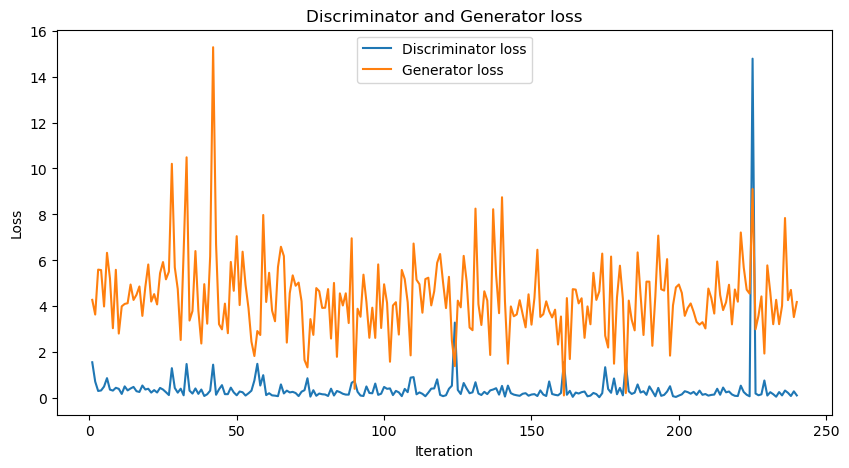

In [6]:
# Parsing the data
loss_d = []
loss_g = []

for line in data.strip().split('\n'):
    parts = line.split()
    d_loss = float(parts[6].strip(','))
    g_loss = float(parts[9])
    
    loss_d.append(d_loss)
    loss_g.append(g_loss)

# X-axis will be a simple count
x_axis = list(range(1, len(loss_d) + 1))

# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(x_axis, loss_d, label='Discriminator loss')
plt.plot(x_axis, loss_g, label='Generator loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Discriminator and Generator loss')
plt.legend()
plt.show()

In [11]:
import cv2
import os

def create_video_from_images(image_folder, output_video_path, fps=4):
    image_files = [f for f in os.listdir(image_folder) if f.startswith("fake_samples_") and f.endswith(".png")]
    image_files.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))

    first_image_path = os.path.join(image_folder, image_files[0])
    frame = cv2.imread(first_image_path)
    height, width, layers = frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        frame = cv2.imread(image_path)
        video.write(frame)

    video.release()
    print(f'Video saved as {output_video_path}')

create_video_from_images(f'{MODEL_PATH}/images', f'{MODEL_PATH}/video/result.mp4', fps=4)

Video saved as gan/video/result.mp4


In [12]:
import cv2
import os

def create_video_from_images(image_folder, output_video_path, fps=4):
    image_files = [f for f in os.listdir(image_folder) if f.startswith("fake_samples_") and f.endswith(".png")]
    image_files.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))  # Sort by number

    first_image_path = os.path.join(image_folder, image_files[0])
    full_image = cv2.imread(first_image_path)
    height, width = 64, 64  # We only need the top-left 64x64 section

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        full_image = cv2.imread(image_path)
        top_left_corner = full_image[0:64, 0:64]
        video.write(top_left_corner)

    video.release()
    print(f'Video saved as {output_video_path}')

create_video_from_images(f'{MODEL_PATH}/images', f'{MODEL_PATH}/video/result_one_image.mp4', fps=4)

Video saved as gan/video/result_one_image.mp4
